# Leah Branstetter Final Project
## Machine Learning Winter 2025

### Import statements:

In [1]:
# library imports:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# import models and functions from sklearn:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, roc_curve, accuracy_score, silhouette_score, rand_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier

# data imports:
testdata=pd.read_csv('test.csv')
trainingdata=pd.read_csv('training.csv')

#check imports:
trainingdata.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category
0,1,False,"11 12, 2016",C413C78E10E54C5DB41837889F36C1E8,565D194F38B1CC3F806EE677C61F639C,465E154EC79AFFAB5EB2607198B21433,all of the reviews for this product are fake.,"All fake reviews, beware.",1478908800,2.0,NaN,{'Size:': ' Polaris H4'},automotive
1,1,True,"12 6, 2016",490AE37808EFEE3AF4FE6DEBDEB5A4C8,0D66512A0A7F580523AB996378DF0F14,760C63E8E5E8DC3FAA01878D37BA5678,wrong part. our fault.,One Star,1480982400,NaN,NaN,NaN,automotive


## Binary Classification:

### Processing Data

In [3]:

# Preprocessing: Handle missing values, encode categorical features, vectorize text
# function to process data (we will call this once on training data and once on test data):
# OK so low key it only worked for the training data and I wrote another one down below for the test data rip
def preprocess_data(data):
    
    # Fill in "Missing" for missing data if data is a string
    data['summary'] = data['summary'].fillna('Missing')
    data['reviewerName'] = data['reviewerName'].fillna('Missing')
    categories = data['category']
    
    # Assigning 0 or 1 depending on what category it is
    print("encoding")
    label_encoder = LabelEncoder()
    encoded_int = label_encoder.fit_transform(categories)
    encoded_int = encoded_int.reshape(len(encoded_int), 1)   
    OneHot_encoder = OneHotEncoder(sparse_output = False)
    OHE = OneHot_encoder.fit_transform(encoded_int)    
    encoded_cols = pd.DataFrame(OHE, columns = ["cds", "automotive", "cell_phones", "grocery", "sports", "toys"])
    
    # Add encoded columns into data
    data = pd.concat([data, encoded_cols], axis = 1)
    
    # Verified column to 1 if true and 0 if false
    data["verified"] = data["verified"].replace({True: 1, False: 0})
    
    # Handle missing votes
    data["vote"] = data["vote"].fillna(data["vote"].mean())
    
    # 1 if image exists (0 if it doesn't)
    data['image'] = data.image.notnull().astype('int')
    
    # Vectorize
    print("vectorizing")
    tfidf = TfidfVectorizer(lowercase = True, ngram_range = (1,3), max_features = 700, max_df = 0.85, min_df = 0.001, stop_words = ["the", "a", "an", "is", "of", "at", "because", "was"]) 
    
    # Concat summary and review text
    data['review']= data['reviewText'] + data['summary']
    data['review'] = data['review'].str.replace(r'[^\w\s]', ' ', regex=True)
    
    vectorized_reviews = (tfidf.fit_transform(data['review']))   
    reviews = vectorized_reviews.toarray()
    print(reviews.shape)   
    vecdata = data[["verified", "image", "automotive", "cds", "cell_phones", "grocery", "sports", "toys"]]
    vecdata = vecdata.to_numpy()
    print(vecdata.shape)
    
    features = np.concatenate((reviews, vecdata), axis = 1)
    print(features.shape)
    
    # 5-fold cross validation
    cross_validation = KFold(n_splits = 5, shuffle = True, random_state = 1)

    return features, reviews, vecdata

# process the data sets:
# train_features, train_reviews, train_data = preprocess_data(trainingdata)
test_features, test_reviews, test_data = preprocess_data(testdata)

# This is kinda the same thing as above but I realized I needed slightly different return statements
def preprocess_data_train(data):
    # Fill in "Missing" for missing data if data is a string
    data['summary'] = data['summary'].fillna('Missing')
    data['reviewerName'] = data['reviewerName'].fillna('Missing')
    categories = data['category']
    
    # Assigning 0 or 1 depending on what category it is
    print("encoding")
    label_encoder = LabelEncoder()
    encoded_int = label_encoder.fit_transform(categories)
    encoded_int = encoded_int.reshape(len(encoded_int), 1)   
    OneHot_encoder = OneHotEncoder(sparse_output = False)
    OHE = OneHot_encoder.fit_transform(encoded_int)    
    encoded_cols = pd.DataFrame(OHE, columns = ["cds", "automotive", "cell_phones", "grocery", "sports", "toys"])
    
    # Add encoded columns into data
    data = pd.concat([data, encoded_cols], axis = 1)
    
    # Verified column to 1 if true and 0 if false
    data["verified"] = data["verified"].replace({True: 1, False: 0})
    
    # Handle missing votes
    data["vote"] = data["vote"].fillna(data["vote"].mean())
    
    # 1 if image exists (0 if it doesn't)
    data['image'] = data.image.notnull().astype('int')
    
    # Vectorize
    print("vectorizing")
    tfidf = TfidfVectorizer(lowercase = True, ngram_range = (1,3), max_features = 700, max_df = 0.85, min_df = 0.001, stop_words = ["the", "a", "an", "is", "of", "at", "because", "was"]) 
    
    # Concat summary and review text
    data['review'] = data['reviewText'] + data['summary']
    data['review'] = data['review'].str.replace(r'[^\w\s]', ' ', regex=True)
    
    vectorized_reviews = tfidf.fit_transform(data['review'])   
    reviews = vectorized_reviews.toarray()
    print(reviews.shape)   
    
    vecdata = data[["verified", "image", "automotive", "cds", "cell_phones", "grocery", "sports", "toys"]]
    vecdata = vecdata.to_numpy()
    print(vecdata.shape)
    
    # Concatenate review features and vectorized categorical features
    features = np.concatenate((reviews, vecdata), axis = 1)
    print(features.shape)
    
    # Return features and target variable ("overall")
    return features, data["overall"]  # Return the features and the target

# Process the datasets
train_features, train_labels = preprocess_data_train(trainingdata)
#test_features, test_labels = preprocess_data_test(testdata)



encoding
vectorizing


C:\Users\llbra\AppData\Local\Temp\ipykernel_62392\2118394798.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["verified"] = data["verified"].replace({True: 1, False: 0})


(4500, 700)
(4500, 8)
(4500, 708)
encoding
vectorizing


C:\Users\llbra\AppData\Local\Temp\ipykernel_62392\2118394798.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["verified"] = data["verified"].replace({True: 1, False: 0})


(29189, 700)
(29189, 8)
(29189, 708)


### Helper Functions for Model Evaluation and Graphing

In [4]:
# Separate the data into above and below the cutoff:
def cutoff_separate(cutoff):
    cutoffSet = []
    for i in trainingdata['overall']:
        if i > cutoff:
            cutoffSet.append(1)
        else:
            cutoffSet.append(0)
    return cutoffSet
    
# Evaluate the model
def evaluate_model(model, X_test, y_real):
    # get y predictions from the test data:
    y_pred = model.predict(X_test)
    # get probabilities:
    y_prob = model.predict_proba(X_test)[:, 1]

    # calculate various evaluation metrics:
    f1 = f1_score(y_test, y_pred, average = "macro")
    cm = confusion_matrix(y_real, y_pred)
    roc_auc = roc_auc_score(y_real, model.predict_proba(X_test)[:, 1])
    acc = accuracy_score(y_real, y_pred)

    #print results
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {acc}")
    print(f"Confusion Matrix:\n{cm}")
    ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1]).plot()
    print(f"ROC AUC: {roc_auc}")
    RocCurveDisplay.from_predictions(y_real, y_prob)  #check this it might not be how this works
    plt.show()


# graphing for the multiclass evaluations
def multi_class_eval(model, X_test, y_real, y_train):
    # get y predictions from the test data:
    y_pred = model.predict(X_test)
    # get probabilities:
    y_prob = model.predict_proba(X_test)
    
    #calculate various evaluation metrics:
    cm = confusion_matrix(y_real, y_pred)
    f1 = f1_score(y_real, y_pred, average='macro')
    acc = accuracy_score(y_real, y_pred)
    # make sure y_test is defined globally
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class= "ovr", average = "micro")

    #print results:
    print(f"Confusion Matrix:\n{cm}")
    ConfusionMatrixDisplay(confusion_matrix = cm).plot()
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {acc}")
    
    # Binarizer to transform the true labels for the ROC curve
    binarizer = LabelBinarizer().fit(y_test)  # changed y_train to y_test
    bin_y = binarizer.transform(y_real)

    print(f"ROC AUC: {roc_auc}")

    #Graph ROC curves
    figure, axis = plt.subplots(figsize = (6, 6))

    # Make the plot rainfow :)
    colors = ["red", "orange", "gold", "green", "royalblue", "mediumpurple"]
    
    # Multiclass classification case
    print("y_prob shape: ",y_prob.shape)
    print("bin_y shape: ", bin_y.shape)
    for i in range(y_prob.shape[1]):
        RocCurveDisplay.from_predictions(bin_y[:, i], y_prob[:, i], name=f"Class {i + 1}", color=colors[i], ax=axis)
    
    # Display average ROC curve
    RocCurveDisplay.from_predictions(bin_y.ravel(), y_prob.ravel(), name="average", color="black", ax=axis)

    
    # plot titles and formatting
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()
    

### Logistic Regression:

running
Cutoff:  1
Mean 5-fold cross-validation test score:  [0.65167892 0.65167892 0.64400346 0.64400346 0.71057576 0.71057576
 0.75999912 0.75999912 0.69801117 0.69801117 0.69533847 0.69533847
 0.73828025 0.73828025 0.7609777  0.7609777  0.72456867 0.72456867
 0.71963259 0.71963259 0.75034268 0.75034268 0.76277581 0.76277581
 0.72749143 0.72737512 0.72232054 0.72232054 0.75090505 0.75098641
 0.76354664 0.76354664 0.729724   0.729724   0.72570773 0.72570773
 0.75218002 0.75218002 0.76392206 0.76392206 0.73004635 0.73004635
 0.72572398 0.72572398 0.7522058  0.7522058  0.76375604 0.76375604
 0.73119558 0.73119558 0.72648219 0.72648219 0.75257877 0.75257877
 0.76451156 0.76451156 0.7359581  0.7359581  0.72850058 0.72850058
 0.75288175 0.75288175 0.76362392 0.76362392 0.73868996 0.73868996
 0.73423003 0.73423003 0.75469422 0.75469422 0.76349804 0.76349804
 0.74824948 0.74824948 0.7456539  0.7456539  0.75431927 0.75431927
 0.76284159 0.76284159 0.7533708  0.75356661 0.74822112 0.74822112
 

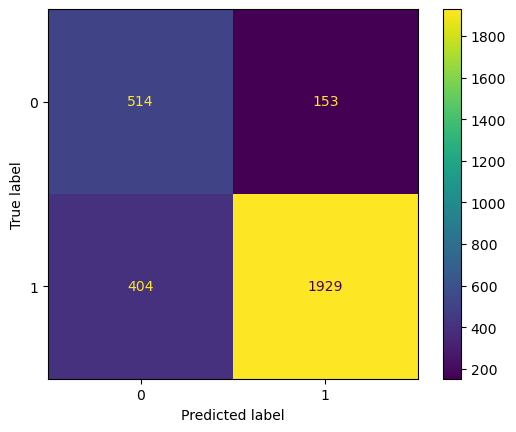

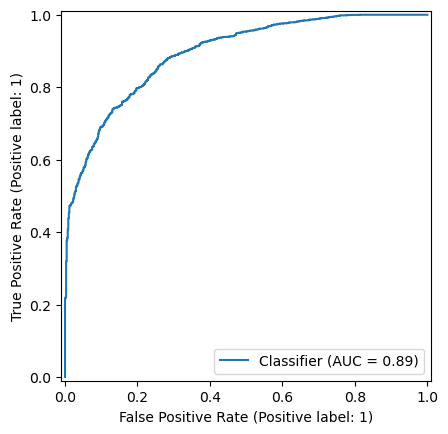

None
Cutoff:  2
Mean 5-fold cross-validation test score:  [0.71353589 0.71353589 0.75839883 0.75839883 0.73239618 0.73239618
 0.77520303 0.77520303 0.76231454 0.76239297 0.77851445 0.77851445
 0.76814027 0.76814027 0.78383688 0.78383688 0.77460097 0.77460097
 0.78274736 0.78274736 0.77345549 0.77353557 0.78546395 0.78546395
 0.77604659 0.77604659 0.78317161 0.78317161 0.77374951 0.77374951
 0.7852795  0.7852795  0.77745812 0.77745812 0.783247   0.783247
 0.77456473 0.77456473 0.78596451 0.78596451 0.7774752  0.7774752
 0.78348161 0.78348161 0.7761289  0.7761289  0.78637219 0.78637219
 0.77783175 0.77783175 0.78360635 0.78360635 0.77611115 0.77602198
 0.78666576 0.78666576 0.77841696 0.77841696 0.783787   0.783787
 0.7770509  0.77722016 0.78734392 0.78734392 0.77859708 0.77851827
 0.78473981 0.78473981 0.77780712 0.77780712 0.78678975 0.78678975
 0.78062436 0.78062436 0.78491167 0.78491167 0.78253748 0.78253748
 0.78567375 0.78567375 0.78312187 0.78312187 0.78519239 0.78519239
 0.783704

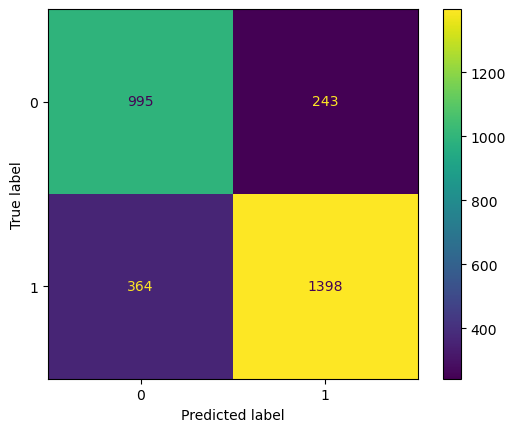

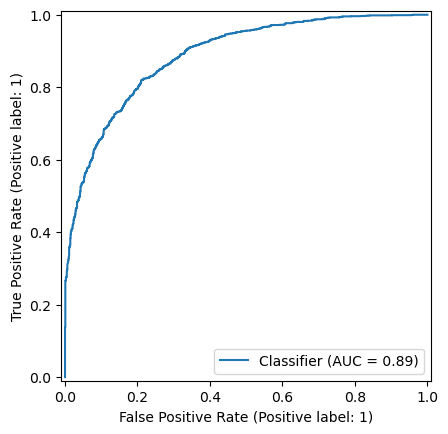

None
Cutoff:  3
Mean 5-fold cross-validation test score:  [0.71935145 0.71935145 0.74699223 0.74699223 0.74483433 0.74483433
 0.78427895 0.78427895 0.76688193 0.76696081 0.77714034 0.77714034
 0.77658451 0.77658451 0.79065562 0.79065562 0.78229003 0.78229003
 0.78623547 0.78623547 0.78886541 0.78886541 0.79269958 0.79269958
 0.7837714  0.7837714  0.78766774 0.78766774 0.78968516 0.78968516
 0.79255632 0.79255632 0.78550941 0.7854043  0.78904305 0.78904305
 0.79017889 0.79017889 0.79353149 0.79353149 0.78592818 0.78592818
 0.78896069 0.78896069 0.79017609 0.79017609 0.79362681 0.79362681
 0.7860904  0.78617121 0.78934555 0.78934555 0.79163092 0.79163092
 0.79364062 0.79364062 0.78674821 0.78674821 0.79009809 0.79009809
 0.79146416 0.79146416 0.79372168 0.79372168 0.78807677 0.78807677
 0.79081127 0.79081127 0.79288128 0.79288128 0.79451531 0.79451531
 0.79377865 0.79369812 0.79312494 0.79312494 0.79185152 0.79185152
 0.79502437 0.79502437 0.79382133 0.79382133 0.7946462  0.7946462
 0.79

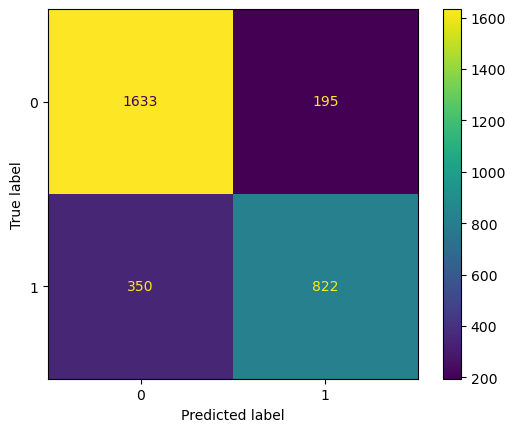

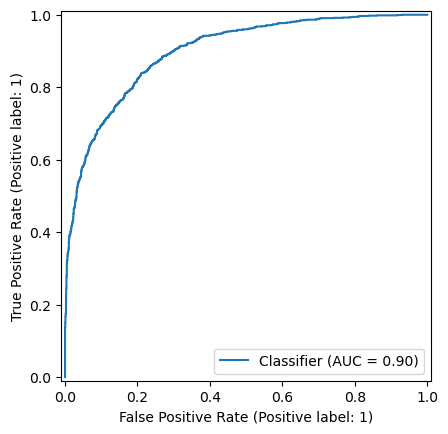

None
Cutoff:  4
Mean 5-fold cross-validation test score:  [0.6525648  0.6525648  0.63197152 0.63197152 0.70038052 0.70038052
 0.75182283 0.75182283 0.69662184 0.69662184 0.68121407 0.68121407
 0.73385923 0.73385923 0.75904105 0.75904105 0.72052767 0.72052767
 0.7063326  0.7063326  0.74333184 0.74333184 0.7582849  0.7582849
 0.72309513 0.72309513 0.71014483 0.71014483 0.74380013 0.74380013
 0.75843448 0.75843448 0.72526897 0.72526897 0.71407447 0.71407447
 0.74475307 0.74475307 0.75857902 0.75857902 0.72534394 0.72534394
 0.71508759 0.71508759 0.74405048 0.74405048 0.75858074 0.75858074
 0.72608645 0.72608645 0.71656522 0.71656522 0.74430242 0.74430242
 0.75818671 0.75818671 0.72842291 0.72842291 0.71862182 0.71862182
 0.7445785  0.7445785  0.75864606 0.75864606 0.73310328 0.73310328
 0.72154967 0.72154967 0.74542772 0.74542772 0.75818521 0.75818521
 0.74616437 0.74616437 0.73116868 0.73116868 0.74969125 0.74960751
 0.75827433 0.75827433 0.75070277 0.75070277 0.73568323 0.73568323
 0.75

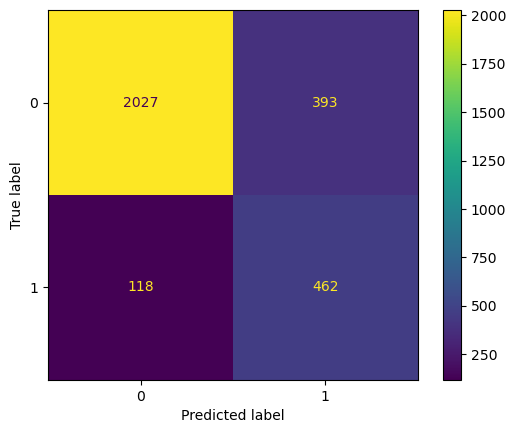

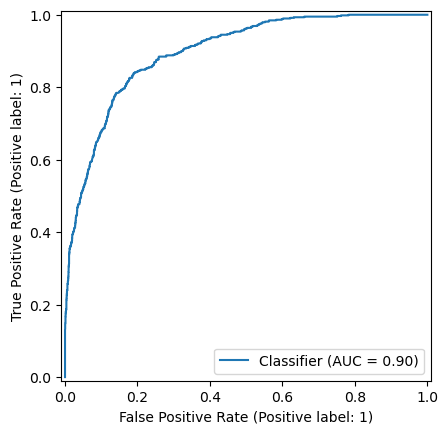

None


In [7]:
# Run Logistic regression 5 times, once for each cutoff:
print("running")
for i in range(1,5):

    print("Cutoff: ", i)
    # separate the cutoffs into 0 if below the cutoff and 1 if above it
    cutoffs = cutoff_separate(i)
    # split the training data into training and testing
    x_train, x_test, y_train, y_test = train_test_split(train_features[0:15000], cutoffs[0:15000], test_size = 0.2, random_state = 1)

    # parameter tuning:
    # At first I tried with a few other hyperparameters including newton-cg as a solver and elastinet as a penalty, 
    # but I ran into issues with some of the hyper-parameters only working with specfic combinations of the other hyper-parameters, 
    # so I got rid of newton-cg and elastinet
    param_grid = {
    # After a first run with [0.05, 0.1, 0.25, 0.5, 0.75, 1] as C values, 0.5 was the best value, so I added values closer to 0.5 and got rid of 1, 0.1, 0.25, and .05
    # After a second run with [0.4, 0.45, 0.5, 0.55, 0.6, 0.75], 0.45 came back as the best C value, so I added values closer to 0.45 and got rid of .6 and .75
    # After a third run with [0.4, 0.425, 0.45, 0.46, 0.475, 0.5, 0.55], I realized that some of the different cutoffs used slightly higher numbers, so I added in higher parameters as well
    "C": [0.1, 0.25, 0.4, 0.425, 0.45, 0.46, 0.475, 0.5, 0.55, 0.75, 0.9, 1, 1.1, 1.25],
    "solver": ["liblinear"],
    "penalty": ["l1", "l2"],
    "class_weight": [None, "balanced"],  # Add None as an option for solvers that do not support 'balanced'
    "fit_intercept": [False],
    "warm_start": [True, False]
    }
    params_tune = GridSearchCV(estimator = LogisticRegression(max_iter = 100), param_grid = param_grid, scoring = "f1_macro")
    params_tune.fit(x_train, y_train)

    # print results of parameter tuning
    print("Mean 5-fold cross-validation test score: ", params_tune.cv_results_["mean_test_score"])
    print("Top params used in top estimator: ", params_tune.best_params_)
    print("Mean 5-fold cross-validated score of top estimator: ", params_tune.best_score_)

    # train the model on the best parameters:
    logisticRegression = params_tune.best_estimator_
    logisticRegression.fit(x_train, y_train)    
    
    print("Performance of logistic regression model:")
    print(evaluate_model(logisticRegression, x_test, y_test))
    
# This ended up being my best model so I'm going to make a csv for Kaggle:
# Doing it with the actual data for Kaggle

    # test_pred = logisticRegression.predict(test_features)
    # test_IDs = testdata.index
    # test_submission = pd.DataFrame({'id': test_IDs, 'binary_split_'+str(i): test_pred})
    # test_submission.to_csv('test_submission_' + "LR_cutoff_" + str(i) + ".csv", index = False)
    # print("test submission shape: ", test_submission.shape) # should be 4500, 2
    # test_submission.head()
  

### Random Forest Classifier

Cutoff:  1
Mean 5-fold cross-validation test score:  [0.70085468 0.69652566 0.69115732 0.69242657 0.69385319 0.69592891
 0.69072358 0.70433357 0.69878939 0.69783813 0.69093684 0.69377272
 0.69252163 0.68888052]
Top params used in top estimator:  {'criterion': 'entropy', 'n_estimators': 30}
Mean 5-fold cross-validated score of top estimator:  0.7043335658101011
Performance of Random Forest Classifier model:
F1 Score: 0.9097774244833068
Accuracy: 0.8486666666666667
Confusion Matrix:
[[ 257  410]
 [  44 2289]]
ROC AUC: 0.8641414397816094


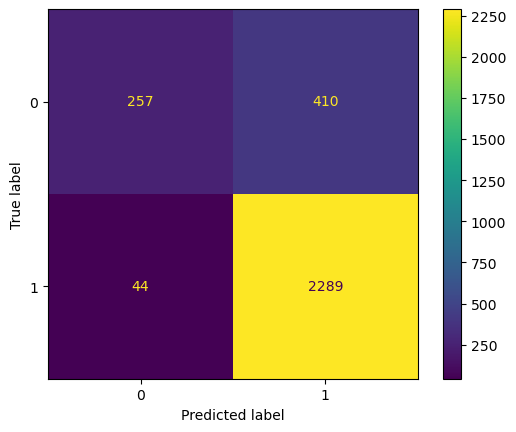

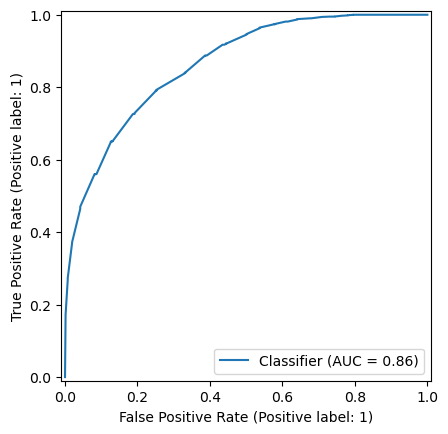

None
Cutoff:  2
Mean 5-fold cross-validation test score:  [0.75604483 0.76287689 0.7675273  0.76837809 0.76818642 0.7736029
 0.77216598 0.75762978 0.76536665 0.77096423 0.77256788 0.77208495
 0.77073915 0.77492537]
Top params used in top estimator:  {'criterion': 'entropy', 'n_estimators': 200}
Mean 5-fold cross-validated score of top estimator:  0.7749253703608877
Performance of Random Forest Classifier model:
F1 Score: 0.8283602518477964
Accuracy: 0.791
Confusion Matrix:
[[ 860  378]
 [ 249 1513]]
ROC AUC: 0.8801532166230547


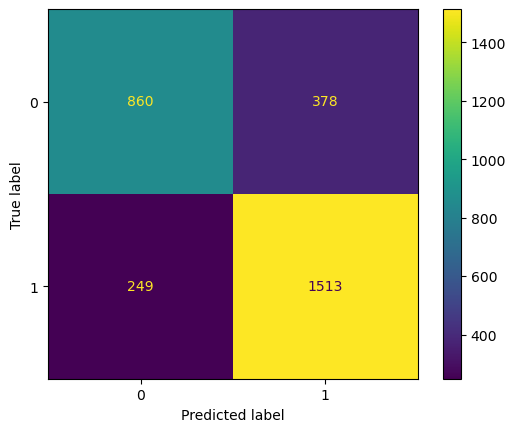

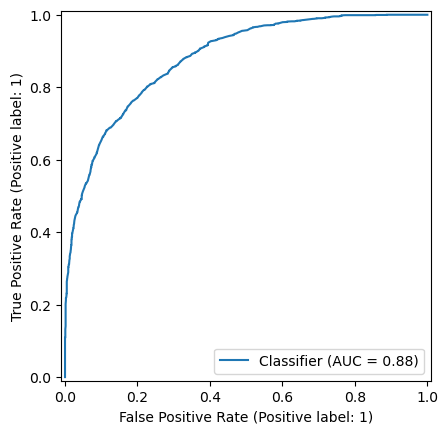

None
Cutoff:  3
Mean 5-fold cross-validation test score:  [0.73963666 0.75281411 0.75053353 0.75722999 0.7546514  0.75624464
 0.76084715 0.75010409 0.75439223 0.76131803 0.7582473  0.76456308
 0.7615891  0.76264112]
Top params used in top estimator:  {'criterion': 'entropy', 'n_estimators': 120}
Mean 5-fold cross-validated score of top estimator:  0.7645630814621797
Performance of Random Forest Classifier model:
F1 Score: 0.6848760748609004
Accuracy: 0.7923333333333333
Confusion Matrix:
[[1700  128]
 [ 495  677]]
ROC AUC: 0.8784967531982584


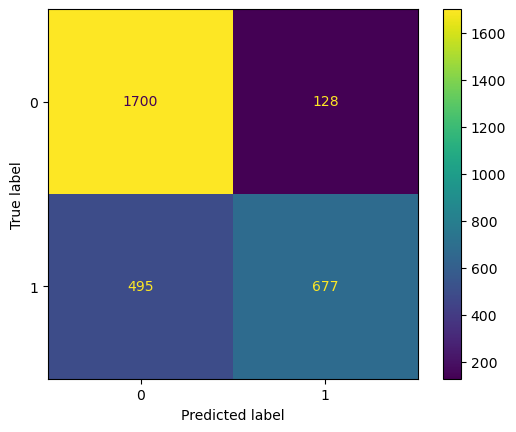

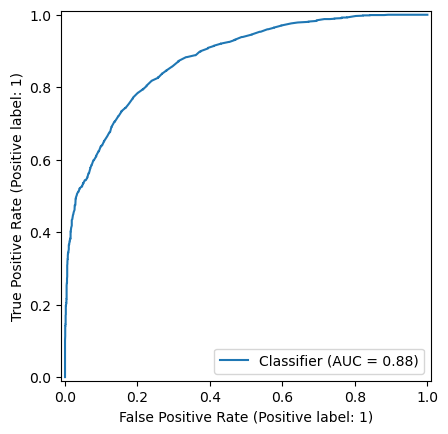

None
Cutoff:  4
Mean 5-fold cross-validation test score:  [0.69458835 0.6955424  0.69700858 0.69583856 0.6957347  0.69742457
 0.69637095 0.69195134 0.69671929 0.69642945 0.69448748 0.6954552
 0.69798989 0.69994841]
Top params used in top estimator:  {'criterion': 'entropy', 'n_estimators': 200}
Mean 5-fold cross-validated score of top estimator:  0.6999484070229756
Performance of Random Forest Classifier model:
F1 Score: 0.519298245614035
Accuracy: 0.863
Confusion Matrix:
[[2367   53]
 [ 358  222]]
ROC AUC: 0.880329509831861


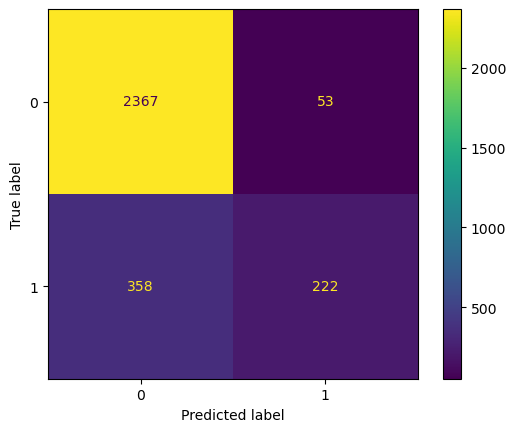

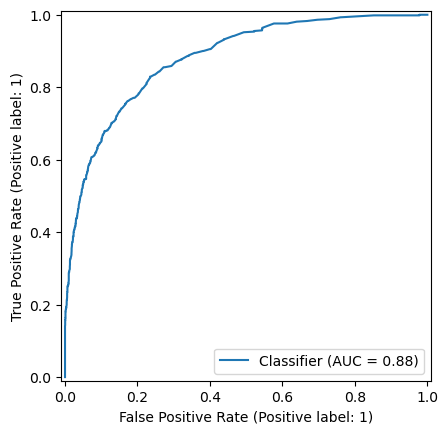

None


In [160]:
# Run Random Forest Classifier 5 times, once for each cutoff:
for i in range(1,5):
    # Same as with Logistic Regression
    print("Cutoff: ", i)
    # separate the cutoffs into 0 if below the cutoff and 1 if above it
    cutoffs = cutoff_separate(i)
    # split the training data into training and testing
    x_train, x_test, y_train, y_test = train_test_split(train_features[0:15000], cutoffs[0:15000], test_size = 0.2, random_state = 1)

    # parameter tuning:
    # first run: n_estimators is between [50, 100, 200, 500], 50 was the most common best value, so I added lower values and got rid of 500 and 200
    # I also received a warning message for the warm start parameter, so I got rid of it. I added a max_features parameter.
    # max_featuers took too long to run so I got rid of it
    # Also I adjusted the esitmators to [30, 50, 70, 100, 120, 150, 200] with cutoff 1 using 30 at the lower end and 200 as the high end
    # to be honest some of the models probably would've 
    param_grid = {
    "n_estimators": [30, 50, 70, 100, 120, 150, 200],
    "criterion": ["gini", "entropy"],
    }
    params_tune = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, scoring = "f1_macro")
    params_tune.fit(x_train, y_train)

    # print results of parameter tuning
    print("Mean 5-fold cross-validation test score: ", params_tune.cv_results_["mean_test_score"])
    print("Top params used in top estimator: ", params_tune.best_params_)
    print("Mean 5-fold cross-validated score of top estimator: ", params_tune.best_score_)

    # train the model on the best parameters:
    RFC = params_tune.best_estimator_
    RFC.fit(x_train, y_train)    
    
    print("Performance of Random Forest Classifier model:")
    print(evaluate_model(RFC, x_test, y_test))

### Naive Bayes:

Cutoff:  1
Mean 5-fold cross-validation test score:  [0.70968989 0.7114751  0.70982764 0.73006187 0.74580539 0.67967342]
Top params used in top estimator:  {'var_smoothing': 0.01}
Mean 5-fold cross-validated score of top estimator:  0.745805387746399
Performance of NaiveBayes model:
F1 Score: 0.8669354838709677
Accuracy: 0.802
Confusion Matrix:
[[ 471  196]
 [ 398 1935]]
ROC AUC: 0.8624979194928897


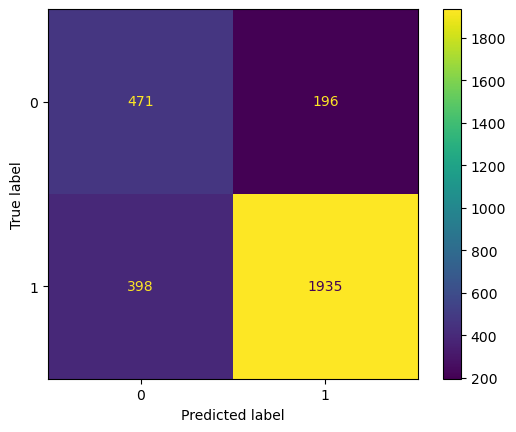

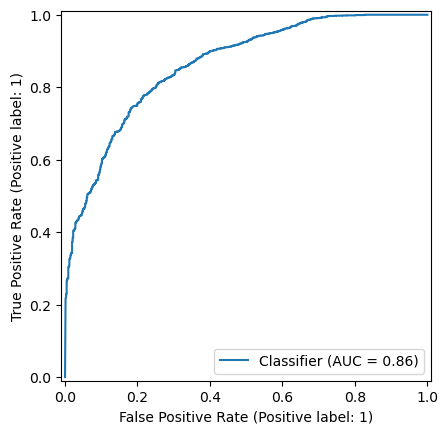

None
Cutoff:  2
Mean 5-fold cross-validation test score:  [0.74093434 0.74355155 0.7416593  0.75132938 0.74291368 0.61345759]
Top params used in top estimator:  {'var_smoothing': 0.005}
Mean 5-fold cross-validated score of top estimator:  0.7513293797894859
Performance of NaiveBayes model:
F1 Score: 0.8095368594135379
Accuracy: 0.7683333333333333
Confusion Matrix:
[[ 828  410]
 [ 285 1477]]
ROC AUC: 0.8516017101289288


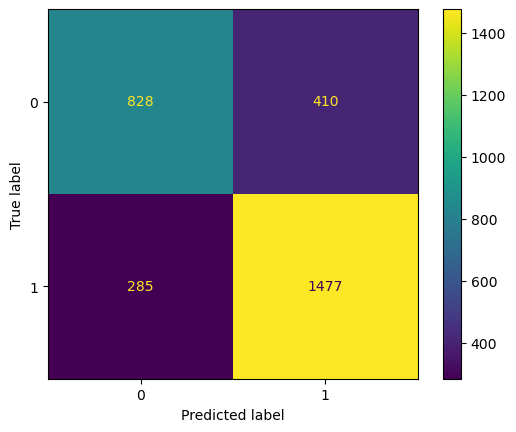

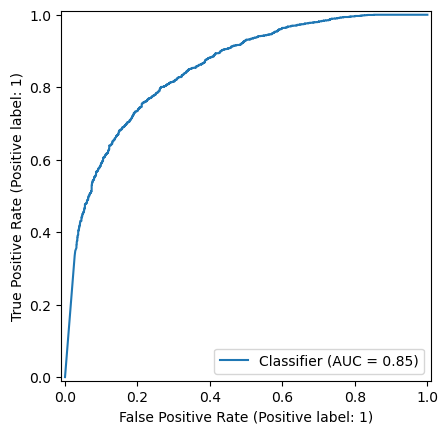

None
Cutoff:  3
Mean 5-fold cross-validation test score:  [0.73249636 0.73631315 0.73603385 0.69312827 0.65454649 0.60657376]
Top params used in top estimator:  {'var_smoothing': 0.0005}
Mean 5-fold cross-validated score of top estimator:  0.73631315278917
Performance of NaiveBayes model:
F1 Score: 0.7221374045801526
Accuracy: 0.7573333333333333
Confusion Matrix:
[[1326  502]
 [ 226  946]]
ROC AUC: 0.8312853339407473


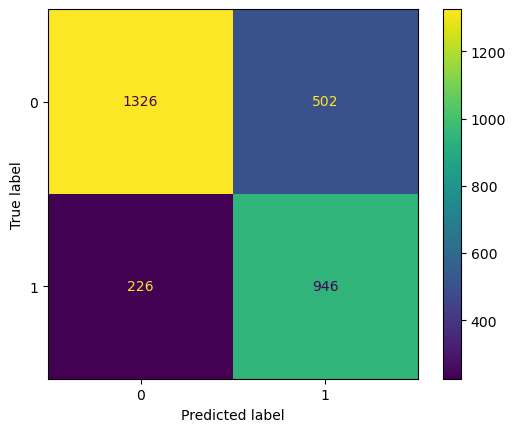

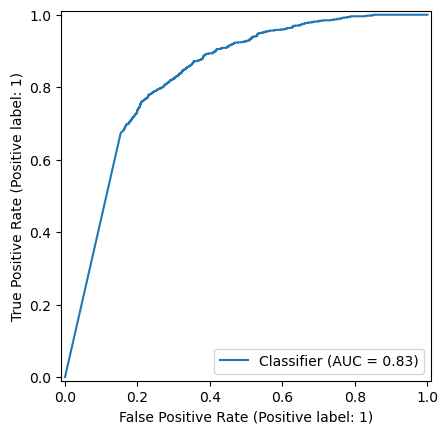

None
Cutoff:  4
Mean 5-fold cross-validation test score:  [0.66460396 0.67084955 0.67452457 0.56954616 0.51102877 0.61947136]
Top params used in top estimator:  {'var_smoothing': 0.0001}
Mean 5-fold cross-validated score of top estimator:  0.6745245669121258
Performance of NaiveBayes model:
F1 Score: 0.5531400966183575
Accuracy: 0.7533333333333333
Confusion Matrix:
[[1802  618]
 [ 122  458]]
ROC AUC: 0.8168744656597322


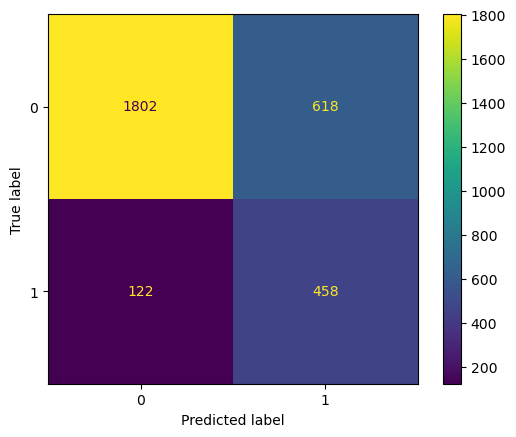

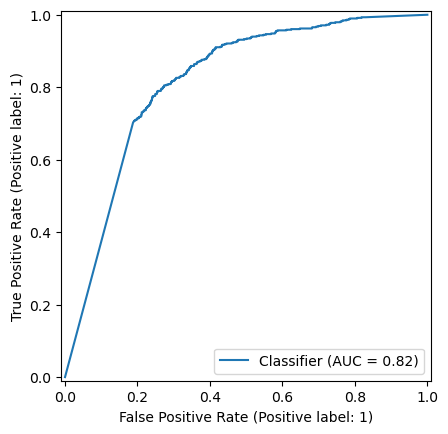

None


In [168]:
# Run Naive Bayes 5 times, once for each cutoff:
for i in range(1,5):
    # Same as with above
    print("Cutoff: ", i)
    # separate the cutoffs into 0 if below the cutoff and 1 if above it
    cutoffs = cutoff_separate(i)
    # split the training data into training and testing
    x_train, x_test, y_train, y_test = train_test_split(train_features[0:15000], cutoffs[0:15000], test_size = 0.2, random_state = 1)

    # parameter tuning:
    # at first I started with really small values [1e-9, 1e-8, 1e-7, 1e-6, 1e-5] but most cutoffs used 1e-5, so I adjusted the values to be greater
    param_grid = {
    'var_smoothing': [1e-5, 0.0005, 0.0001, 0.005, 0.01, 0.05]
    }
    params_tune = GridSearchCV(estimator = GaussianNB(), param_grid = param_grid, scoring = "f1_macro")
    params_tune.fit(x_train, y_train)

    # print results of parameter tuning
    print("Mean 5-fold cross-validation test score: ", params_tune.cv_results_["mean_test_score"])
    print("Top params used in top estimator: ", params_tune.best_params_)
    print("Mean 5-fold cross-validated score of top estimator: ", params_tune.best_score_)

    # train the model on the best parameters:
    NaiveBayes = params_tune.best_estimator_
    NaiveBayes.fit(x_train, y_train)    
    
    print("Performance of NaiveBayes model:")
    print(evaluate_model(NaiveBayes, x_test, y_test))

## Multi-Class Classification

### Support Vector Machines

splitting
tuning
Mean 5-fold cross-validation test score:  [0.50230482 0.39384027 0.40049075 0.51386144 0.50829116 0.46808253
 0.50801608 0.51446246 0.48961559 0.50178457 0.50299531 0.49289454
 0.49771904 0.4966555  0.49023806]
Top params used in top estimator:  {'C': 1, 'kernel': 'rbf'}
Mean 5-fold cross-validated score of top estimator:  0.5144624620960154
Performance of Support Vector Machine model:
Confusion Matrix:
[[444 136  52  19  16]
 [165 235 105  41  25]
 [ 54 127 279  91  39]
 [ 41  74 111 236 130]
 [ 36  31  22 111 380]]
F1 Score: 0.5191040954859693
Accuracy: 0.5246666666666666
ROC AUC: 0.8384973055555556
y_prob shape:  (3000, 5)
bin_y shape:  (3000, 5)


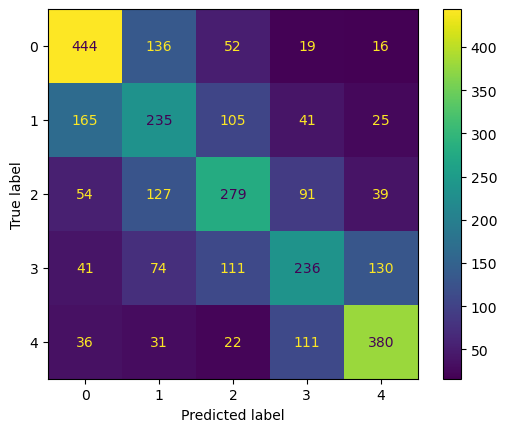

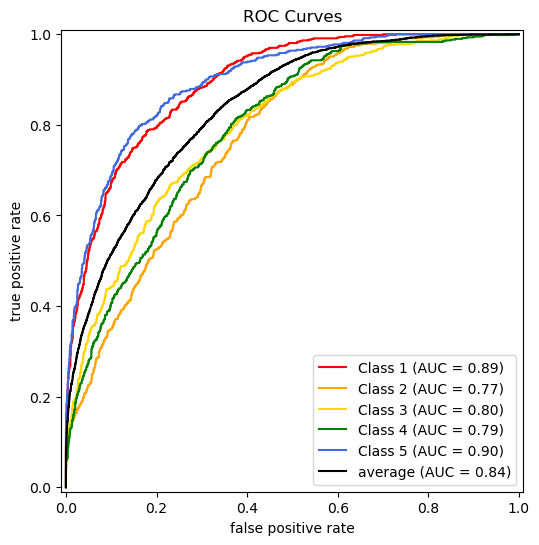

None


In [9]:
# split data into testing and training
print("splitting")
x_train, x_test, y_train, y_test = train_test_split(train_features[0:15000][:], train_labels[0:15000], test_size = 0.2, random_state = 1)

# Parameter Tuning
print("tuning")
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
}

params_tune = GridSearchCV(estimator = SVC(probability=True), param_grid = param_grid, scoring = "f1_macro", cv=5)
params_tune.fit(x_train, y_train)

# Print results of parameter tuning
print("Mean 5-fold cross-validation test score: ", params_tune.cv_results_["mean_test_score"])
print("Top params used in top estimator: ", params_tune.best_params_)
print("Mean 5-fold cross-validated score of top estimator: ", params_tune.best_score_)

# Use the best model from GridSearchCV
SVM = params_tune.best_estimator_
SVM.fit(x_train, y_train)

# Predict using the trained model
y_prediction = SVM.predict(x_test)

# Get predicted probabilities for multi-class evaluation
y_prob = SVM.predict_proba(x_test)

# Print performance of SVM model
print("Performance of Support Vector Machine model:")
print(multi_class_eval(SVM, x_test, y_test, y_train))

### Random Forest Classifier

splitting
tuning
Mean 5-fold cross-validation test score:  [0.46727403 0.47007013 0.48583939 0.48996859 0.45930939 0.4715595
 0.48574774 0.48596984 0.46434701 0.46847252 0.47048389 0.46976321]
Top params used in top estimator:  {'max_features': 'sqrt', 'n_estimators': 300}
Mean 5-fold cross-validated score of top estimator:  0.48996858767449236
Performance of Random Forest model:
Confusion Matrix:
[[476  97  49  23  22]
 [190 185 124  40  32]
 [ 80  99 284  87  40]
 [ 67  68 108 216 133]
 [ 53  44  33  85 365]]
F1 Score: 0.4967840272866722
Accuracy: 0.5086666666666667
ROC AUC: 0.8242542083333333
y_prob shape:  (3000, 5)
bin_y shape:  (3000, 5)


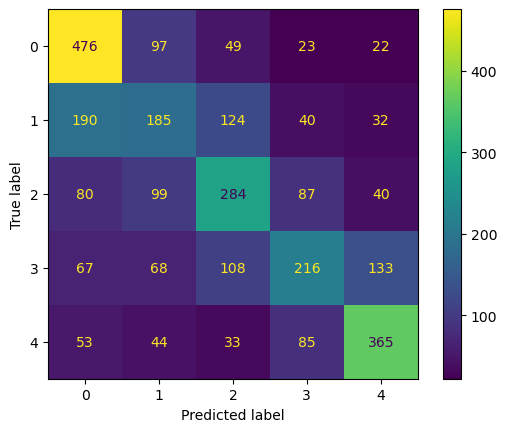

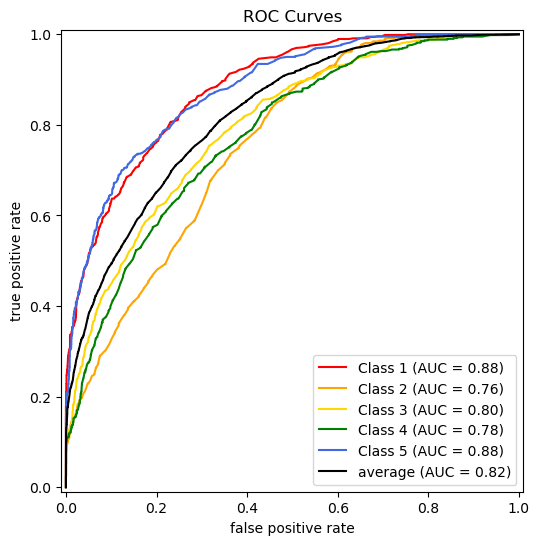

None


In [251]:
# split data into testing and training
print("splitting")
x_train, x_test, y_train, y_test = train_test_split(train_features[0:15000][:], train_labels[0:15000], test_size = 0.2, random_state = 1)

# Parameter Tuning
print("tuning")
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2', None],  # The number of features to consider at each split
}

params_tune = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, scoring = "f1_macro", cv=5)
params_tune.fit(x_train, y_train)

# Print results of parameter tuning
print("Mean 5-fold cross-validation test score: ", params_tune.cv_results_["mean_test_score"])
print("Top params used in top estimator: ", params_tune.best_params_)
print("Mean 5-fold cross-validated score of top estimator: ", params_tune.best_score_)

# Use the best model from GridSearchCV
RF = params_tune.best_estimator_
RF.fit(x_train, y_train)

# Predict using the trained model
y_prediction = RF.predict(x_test)

# Get predicted probabilities for multi-class evaluation
y_prob = RF.predict_proba(x_test)

# Print performance of Random Forest model
print("Performance of Random Forest model:")
print(multi_class_eval(RF, x_test, y_test, y_train))

### K-Nearest Neighbors

splitting
tuninig
Mean 5-fold cross-validation test score:  [0.32314866 0.31515344 0.40897656 0.40901473 0.31529802 0.30977926
 0.42769199 0.42419053 0.30734766 0.30419288 0.43842481 0.43725796
 0.30405475 0.3065709  0.43460904 0.43407055 0.29913079 0.29895711
 0.43478559 0.43580303 0.29517228 0.29600175 0.43563309 0.43714385]
Top params used in top estimator:  {'n_neighbors': 70, 'p': 2, 'weights': 'uniform'}
Mean 5-fold cross-validated score of top estimator:  0.43842481477300044
Performance of K-Nearest Neighbors model:
Confusion Matrix:
[[362 147  64  60  34]
 [125 197 102  84  63]
 [ 63 126 205 116  80]
 [ 53  80  98 235 126]
 [ 44  51  47 104 334]]
F1 Score: 0.4402778286615782
Accuracy: 0.44433333333333336
ROC AUC: 0.7646212638888888
y_prob shape:  (3000, 5)
bin_y shape:  (3000, 5)


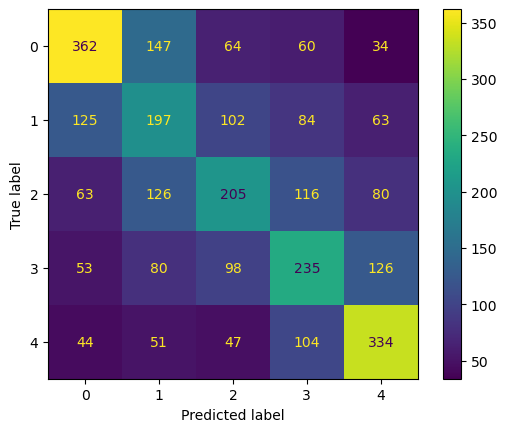

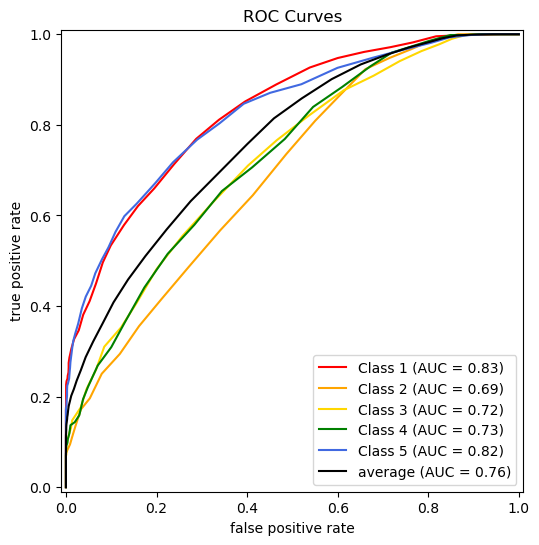

None


In [249]:
# split data into testing and training
print("splitting")
x_train, x_test, y_train, y_test = train_test_split(train_features[0:15000][:], train_labels[0:15000], test_size = 0.2, random_state = 1)

# Parameter Tuning
print("tuninig")
param_grid = {
'n_neighbors' : [30, 50, 70, 80, 90, 100], 
'weights' : ['uniform', 'distance'],
'p': [1, 2]
}
params_tune = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = param_grid, scoring = "f1_macro")
params_tune.fit(x_train, y_train)

# Print results of parameter tuning
print("Mean 5-fold cross-validation test score: ", params_tune.cv_results_["mean_test_score"])
print("Top params used in top estimator: ", params_tune.best_params_)
print("Mean 5-fold cross-validated score of top estimator: ", params_tune.best_score_)

KNN = params_tune.best_estimator_
KNN.fit(x_train, y_train)
y_prediction = KNN.predict(x_test)

y_prob = KNN.predict_proba(x_test)
    
print("Performance of K-Nearest Neighbors model:")
print(multi_class_eval(KNN, x_test, y_test, y_train))

## Clustering

In [275]:
# concatinate reviewText and summary:
testdata["review"]= testdata['reviewText'] + testdata['summary']
testdata['review'] = testdata['review'].str.replace(r'[^\w\s]', ' ', regex=True)

# vectorization
tfidf = TfidfVectorizer(min_df = 0.11, stop_words = "english")
x = tfidf.fit_transform(testdata["review"])

y = testdata["category"].to_numpy()

param_grid = {
"n_clusters": [6], 
"n_init": [10, 20, 30],
"init": ["random", "k-means++"],
"algorithm": ["elkan", "lloyd"]
}

def findBestParams(k_means, x, y):
    y_pred = k_means.fit_predict(x)
    silhouette = silhouette_score(x, y_pred)
    r_index = rand_score(labels_true = y.ravel(), labels_pred = y_pred)
    return (r_index + silhouette)

params_tune = GridSearchCV(estimator = KMeans(), param_grid = param_grid, scoring = findBestParams)
params_tune.fit(x, y)

print("Mean 5-fold cross-validation test score: ", params_tune.cv_results_["mean_test_score"])
print("Top params used in top estimator: ", params_tune.best_params_)
print("Mean 5-fold cross-validated score of top estimator: ", params_tune.best_score_)

# kmeans clustering
kmeans = params_tune.best_estimator_
pred = kmeans.predict(x)

# silhouette score
labels = kmeans.labels_
silhouette_average = silhouette_score(x, pred)
print("Silhouette Score:", silhouette_average)

# rand index
rand_index = rand_score(labels_true = y.ravel(), labels_pred = pred)
print("Rand Index: ", rand_index)

Mean 5-fold cross-validation test score:  [1.08056714 1.07913401 1.0816603  1.08067357 1.08126046 1.08230149
 1.0790964  1.08058327 1.07999058 1.08121699 1.08110552 1.08147849]
Top params used in top estimator:  {'algorithm': 'elkan', 'init': 'k-means++', 'n_clusters': 6, 'n_init': 30}
Mean 5-fold cross-validated score of top estimator:  1.0823014877571804
Silhouette Score: 0.6275316312755629
Rand Index:  0.7008640932552913
